In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim  

import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en.stop_words import STOP_WORDS

from textblob import TextBlob

from tqdm import tqdm_notebook as tqdm
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

C:\Users\HP\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\HP\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [2]:
df1 = pd.read_csv('ethiopia_tripadvisor_data_model_3.csv')
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"['Amazing', 'location', 'must', 'visit.']"
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"['I', 'do', 'recommend', 'to', 'visit', 'Lalib..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"['A', 'must', 'visit', 'in', 'Ethiopia', '-', ..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"['These', 'churches', 'have', 'to', 'be', 'see..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"['Thanks', 'to', 'our', 'tour', 'organiser', '..."


In [3]:
df1['RH_Split'] = df1['Review Head'].apply(lambda x: x.split(' '))
df1['RB_Split'] = df1['Review Body'].apply(lambda x: x.split(' '))
df1['RT_Split'] = df1['Review Text'].apply(lambda x: x.split(' '))
df1['RB_Sentence1_Split'] = df1['RB_Sentence1'].apply(lambda x: x.split(' '))
df1.head()

,Destination Name,Destination Type,Review Head,Review Body,Review Text,RB_Sentence1,TextBlob Polarity Head,TextBlob Polarity Body,TextBlob Polarity Text,TextBlob Polarity RBS1,RB_Sentence1_Split,RH_Split,RB_Split,RT_Split
0,Rock-Hewn Churches of Lalibela,Landmarks,Incredible locations don't be put off thinking...,Amazing location must visit. This site is mark...,Incredible locations don't be put off thinking...,Amazing location must visit.,-0.05,0.300000,0.125000,0.6000,"[Amazing, location, must, visit.]","[Incredible, locations, don't, be, put, off, t...","[Amazing, location, must, visit., This, site, ...","[Incredible, locations, don't, be, put, off, t..."
1,Rock-Hewn Churches of Lalibela,Landmarks,It is a real miracle of the world!,I do recommend to visit Lalibela churches and ...,It is a real miracle of the world! I do recomm...,I do recommend to visit Lalibela churches and ...,0.25,-0.150000,-0.016667,0.0000,"[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!]","[I, do, recommend, to, visit, Lalibela, church...","[It, is, a, real, miracle, of, the, world!, I,..."
2,Rock-Hewn Churches of Lalibela,Landmarks,Incredible experience,A must visit in Ethiopia - one of the most uni...,Incredible experience A must visit in Ethiopia...,A must visit in Ethiopia - one of the most uni...,0.90,0.345000,0.483750,0.4375,"[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, ]","[A, must, visit, in, Ethiopia, -, one, of, the...","[Incredible, experience, A, must, visit, in, E..."
3,Rock-Hewn Churches of Lalibela,Landmarks,Amazing,These churches have to be seen to be believed....,Amazing These churches have to be seen to be b...,These churches have to be seen to be believed.,0.60,0.225000,0.350000,0.0000,"[These, churches, have, to, be, seen, to, be, ...",[Amazing],"[These, churches, have, to, be, seen, to, be, ...","[Amazing, These, churches, have, to, be, seen,..."
4,Rock-Hewn Churches of Lalibela,Landmarks,So much history,Thanks to our tour organiser Ephram who is bas...,So much history Thanks to our tour organiser E...,Thanks to our tour organiser Ephram who is bas...,0.20,0.233333,0.228571,0.2000,"[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history]","[Thanks, to, our, tour, organiser, Ephram, who...","[So, much, history, Thanks, to, our, tour, org..."


In [4]:
df1['Destination Type'].value_counts()

Landmarks       3803
Museums         2507
Nature/Parks    2001
Name: Destination Type, dtype: int64

### Topic Modelling

In [5]:
# NLTK Stop words
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

test_subset = df1['RB_Split'].values
sid = SentimentIntensityAnalyzer()
pos_word_list=[]
neu_word_list=[]
neg_word_list=[]

for value in test_subset:
    for word in value:
        if (sid.polarity_scores(word)['compound']) >= 0.4:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.4:
            print
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

print('Positive :', len(pos_word_list))       
print('Neutral :', len(neu_word_list))    
print('Negative :', len(neg_word_list)) 

Positive : 13151
Neutral : 309837
Negative : 1632


In [6]:
from nltk.corpus import stopwords

main_stop_words = ['ethiopia', 'ethiopian', 'rock', 'hewn', 'church', 'churches', 'park', 'parks', 'museum', 
                       'museums', 'omo', 'valley', 'mountain', 'mountains', 'addis', 'ababa', 'lucy', 'simien', 
                       'national', 'lalibela', 'gelada', 'haile', 'selassie', 'gondar', 'africa' , 'harar', 
                       'cathedral', 'cathedrals', 'place', 'visit', 'girmay', 
                       '\n', '‘s']
positive_stop_words = list(set(pos_word_list))
negative_stop_words = list(set(neg_word_list))
total_stop_words = main_stop_words + positive_stop_words + negative_stop_words

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
stop_words.extend(total_stop_words)
print('Stop Words: ', len(stop_words))

Stop Words:  1724


In [7]:
# Convert to list
data = df1[df1['Destination Type'] == 'Landmarks'][df1['TextBlob Polarity Body'] > 0]['Review Body'].values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Amazing location must visit. This site is marketed as churches but I think '
 'it is actually a rock city as there are no records of when they were built '
 'and who built them. Must see.']


In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['amazing', 'location', 'must', 'visit', 'this', 'site', 'is', 'marketed', 'as', 'churches', 'but', 'think', 'it', 'is', 'actually', 'rock', 'city', 'as', 'there', 'are', 'no', 'records', 'of', 'when', 'they', 'were', 'built', 'and', 'who', 'built', 'them', 'must', 'see']]


In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['amazing', 'location', 'must', 'visit', 'this', 'site', 'is', 'marketed', 'as', 'churches', 'but', 'think', 'it', 'is', 'actually', 'rock', 'city', 'as', 'there', 'are', 'no', 'records', 'of', 'when', 'they', 'were', 'built', 'and', 'who', 'built', 'them', 'must', 'see']


In [10]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [11]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['location', 'site', 'market', 'think', 'actually', 'city', 'record', 'build', 'build', 'see']]


In [12]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1)]]


In [13]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('actually', 1),
  ('build', 2),
  ('city', 1),
  ('location', 1),
  ('market', 1),
  ('record', 1),
  ('see', 1),
  ('site', 1),
  ('think', 1)]]

In [14]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [15]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.073*"wall" + 0.043*"show" + 0.040*"travel" + 0.039*"include" + '
  '0.036*"tribe" + 0.035*"tell" + 0.034*"place" + 0.031*"modern" + '
  '0.029*"locate" + 0.026*"culture"'),
 (1,
  '0.073*"build" + 0.061*"city" + 0.053*"view" + 0.048*"find" + 0.036*"inside" '
  '+ 0.033*"area" + 0.029*"stone" + 0.018*"entrance" + 0.018*"colorful" + '
  '0.017*"road"'),
 (2,
  '0.091*"tour" + 0.051*"monastery" + 0.040*"hour" + 0.035*"town" + '
  '0.022*"knowledgeable" + 0.022*"allow" + 0.018*"read" + 0.018*"famous" + '
  '0.017*"water" + 0.017*"aksum"'),
 (3,
  '0.067*"village" + 0.054*"ancient" + 0.037*"back" + 0.036*"cave" + '
  '0.034*"drive" + 0.033*"new" + 0.029*"high" + 0.025*"historic" + '
  '0.024*"surround" + 0.021*"traditional"'),
 (4,
  '0.056*"people" + 0.055*"worth" + 0.039*"get" + 0.037*"many" + 0.031*"small" '
  '+ 0.030*"trip" + 0.027*"look" + 0.025*"building" + 0.020*"quite" + '
  '0.018*"architecture"'),
 (5,
  '0.059*"see" + 0.051*"guide" + 0.035*"go" + 0.032*"visit" + 0.031*

In [16]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.911021247082237

Coherence Score:  0.38825335461907884


In [19]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.434141  0.096196       1        1  32.026787
4      0.053719 -0.415561       2        1  16.011950
9     -0.056097  0.045469       3        1   8.833109
1     -0.050678  0.032140       4        1   8.267714
2     -0.061032  0.042350       5        1   7.395611
6     -0.057276  0.047184       6        1   7.387684
8     -0.063529  0.042121       7        1   7.081413
0     -0.063432  0.038631       8        1   5.228259
3     -0.066394  0.038279       9        1   5.163001
7     -0.069422  0.033191      10        1   2.604473, topic_info=     Category        Freq           Term       Total  loglift  logprob
266   Default  412.000000           time  412.000000  30.0000  30.0000
86    Default  339.000000           take  339.000000  29.0000  29.0000
6     Default  769.000000            see  769.000000  28.0000  28.0000
18    Default  651.000000          guide  651.000000  27.0000  27.0000
75    Default  269.000000           tour  269.000000  26.0000  26.0000
85    Default  357.000000         people  357.000000  25.0000  25.0000
150   Default  352.000000          worth  352.000000  24.0000  24.0000
1     Default  242.000000          build  242.000000  23.0000  23.0000
2     Default  203.000000           city  203.000000  22.0000  22.0000
79    Default  454.000000             go  454.000000  21.0000  21.0000
168   Default  154.000000           wall  154.000000  20.0000  20.0000
99    Default  411.000000          visit  411.000000  19.0000  19.0000
30    Default  248.000000            get  248.000000  18.0000  18.0000
20    Default  401.000000        history  401.000000  17.0000  17.0000
676   Default  400.000000            old  400.000000  16.0000  16.0000
115   Default  175.000000           view  175.000000  15.0000  15.0000
133   Default  239.000000           many  239.000000  14.0000  14.0000
300   Default  139.000000        village  139.000000  13.0000  13.0000
131   Default  160.000000           find  160.000000  12.0000  12.0000
1809  Default  152.000000      monastery  152.000000  11.0000  11.0000
214   Default  147.000000           know  147.000000  10.0000  10.0000
7     Default  351.000000           site  351.000000   9.0000   9.0000
116   Default  328.000000           also  328.000000   8.0000   8.0000
519   Default  134.000000          large  134.000000   7.0000   7.0000
187   Default  196.000000          small  196.000000   6.0000   6.0000
87    Default  190.000000           trip  190.000000   5.0000   5.0000
26    Default  112.000000        ancient  112.000000   4.0000   4.0000
356   Default  122.000000           year  122.000000   3.0000   3.0000
330   Default  176.000000           look  176.000000   2.0000   2.0000
599   Default  117.000000           hour  117.000000   1.0000   1.0000
...       ...         ...            ...         ...      ...      ...
8     Topic10   44.655380          think   45.488621   3.6295  -3.1489
925   Topic10   41.761635           meet   42.595051   3.6282  -3.2159
95    Topic10   40.208427           name   41.041885   3.6274  -3.2538
338   Topic10   37.406242         enough   38.239567   3.6259  -3.3261
1016  Topic10   34.176617          mural   35.009922   3.6238  -3.4164
3066  Topic10   29.460299         street   30.293762   3.6200  -3.5649
1624  Topic10   23.419130         plenty   24.252554   3.6130  -3.7943
787   Topic10   21.209471       discover   22.042927   3.6094  -3.8934
2195  Topic10   21.091099       somewhat   21.924522   3.6092  -3.8990
578   Topic10   20.950373         review   21.783682   3.6089  -3.9057
585   Topic10   18.165504         arrive   18.998743   3.6031  -4.0484
341   Topic10   17.068708        various   17.902006   3.6003  -4.1106
473   Topic10   16.204193           busy   17.037619   3.5978  -4.1626
528   Topic10   16.090588    informative   16.923878   3.5974  -4.1697
871   Topic10   15.185681          carry   

In [18]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
import os
os.environ.update({'MALLET_HOME':r'C:/Users/HP/mallet-2.0.8/'})
mallet_path = r'C:\Users\HP\mallet-2.0.8\bin\mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

In [20]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('day', 0.12025316455696203),
   ('trip', 0.06550632911392405),
   ('recommend', 0.03069620253164557),
   ('spend', 0.028164556962025317),
   ('pay', 0.024683544303797468),
   ('highlight', 0.021518987341772152),
   ('price', 0.020569620253164556),
   ('stop', 0.016139240506329113),
   ('hotel', 0.015822784810126583),
   ('bring', 0.015189873417721518)]),
 (1,
  [('people', 0.08964451313755796),
   ('view', 0.05873261205564142),
   ('top', 0.03894899536321484),
   ('priest', 0.029057187017001544),
   ('picture', 0.025965996908809894),
   ('include', 0.025656877897990725),
   ('water', 0.023183925811437404),
   ('sight', 0.017619783616692426),
   ('tree', 0.01731066460587326),
   ('local', 0.017001545595054096)]),
 (2,
  [('guide', 0.1924698795180723),
   ('history', 0.11114457831325301),
   ('tour', 0.086144578313253),
   ('experience', 0.06987951807228916),
   ('local', 0.04156626506024096),
   ('explain', 0.022289156626506025),
   ('knowledgeable', 0.01746987951807229),
   ('

2
3
4
5
6
7
8
9
10


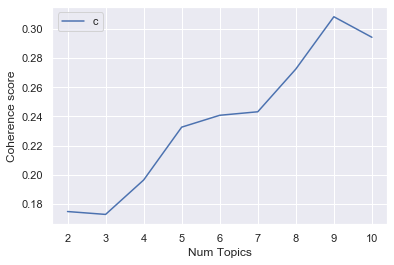

In [21]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 2 
limit1 = 11
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.1748
Num Topics = 3  has Coherence Value of 0.1728
Num Topics = 4  has Coherence Value of 0.1964
Num Topics = 5  has Coherence Value of 0.2326
Num Topics = 6  has Coherence Value of 0.2407
Num Topics = 7  has Coherence Value of 0.2431
Num Topics = 8  has Coherence Value of 0.2724
Num Topics = 9  has Coherence Value of 0.3083
Num Topics = 10  has Coherence Value of 0.2942


In [23]:
optimal_model = model_list[7] # Number of Topics = 9
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.070*"experience" + 0.059*"guide" + 0.049*"small" + 0.028*"service" + '
  '0.025*"bit" + 0.023*"pay" + 0.021*"ticket" + 0.019*"price" + 0.018*"high" + '
  '0.018*"picture"'),
 (1,
  '0.122*"guide" + 0.103*"history" + 0.080*"tour" + 0.032*"city" + '
  '0.029*"travel" + 0.027*"recommend" + 0.023*"include" + 0.021*"explain" + '
  '0.018*"highlight" + 0.016*"knowledgeable"'),
 (2,
  '0.077*"make" + 0.055*"local" + 0.036*"give" + 0.031*"feel" + '
  '0.031*"incredible" + 0.030*"work" + 0.029*"tomb" + 0.029*"world" + '
  '0.028*"place" + 0.021*"photo"'),
 (3,
  '0.046*"carve" + 0.035*"building" + 0.033*"wall" + 0.032*"ground" + '
  '0.030*"stone" + 0.029*"architecture" + 0.027*"structure" + 0.026*"back" + '
  '0.025*"ancient" + 0.024*"religious"'),
 (4,
  '0.057*"painting" + 0.042*"lot" + 0.037*"worth" + 0.032*"inside" + '
  '0.029*"climb" + 0.028*"enter" + 0.024*"show" + 0.024*"historical" + '
  '0.022*"shoe" + 0.021*"story"'),
 (5,
  '0.087*"site" + 0.075*"build" + 0.038*"year" + 0

In [24]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,5.0,0.1618,"site, build, year, unique, cave, thing, water,...",Amazing location must visit. This site is mark...
1,1,5.0,0.1342,"site, build, year, unique, cave, thing, water,...",A must visit in Ethiopia - one of the most uni...
2,2,4.0,0.1876,"painting, lot, worth, inside, climb, enter, sh...",These churches have to be seen to be believed....
3,3,2.0,0.1437,"make, local, give, feel, incredible, work, tom...",Thanks to our tour organiser Ephram who is bas...
4,4,2.0,0.1599,"make, local, give, feel, incredible, work, tom...",Truly a marvel of early architecture and craft...
5,5,0.0,0.1403,"experience, guide, small, service, bit, pay, t...","Please I insist anyone reaches Ethiopia,, neve..."
6,6,1.0,0.1559,"guide, history, tour, city, travel, recommend,...",Nothing can quite prepare you for the rock hew...
7,7,1.0,0.1894,"guide, history, tour, city, travel, recommend,...",The rock hewn churches are just amazing. Lalib...
8,8,4.0,0.1358,"painting, lot, worth, inside, climb, enter, sh...",Background: 2 guys in our 30s in Addis for a m...
9,9,7.0,0.1513,"visit, day, time, spend, long, absolutely, imp...",Lalibela has turned out as one of my favourite...


In [25]:
df_dominant_topic['Dominant_Topic'].value_counts()

3.0    422
1.0    422
4.0    384
8.0    378
0.0    378
2.0    365
5.0    347
6.0    344
7.0    318
Name: Dominant_Topic, dtype: int64

In [26]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2674,"experience, guide, small, service, bit, pay, t...","Stunning experience, make sure you do it with ..."
1,1.0,0.2491,"guide, history, tour, city, travel, recommend,...","We did a tour around Harar with Alem, a very f..."
2,2.0,0.2587,"make, local, give, feel, incredible, work, tom...",Beautiful artisanship from more than a millenn...
3,3.0,0.2547,"carve, building, wall, ground, stone, architec...",The huge stone Steles at Axum are still standi...
4,4.0,0.2645,"painting, lot, worth, inside, climb, enter, sh...",The Cathedral is revered by Ethiopians predomi...
5,5.0,0.2187,"site, build, year, unique, cave, thing, water,...",This is a historical site comprised of a summe...
6,6.0,0.2093,"people, find, town, area, tourist, priest, cei...",The walls and ceiling of this church are cover...
7,7.0,0.2293,"visit, day, time, spend, long, absolutely, imp...",We had an amazing guide (Gashaw from Sora Lodg...
8,8.0,0.2929,"worth, walk, trip, view, monastery, top, hour,...",fairly steep and lovely walk on partly paved a...


In [27]:
sent_topics_sorteddf_mallet['Text'].values

array(['Stunning experience, make sure you do it with a guide, and be prepared to pay additional fees at each church, but this is not a con. If your guide allows, you can attend and early morning service. Very welcoming, and humbling to be invited to...',
       'We did a tour around Harar with Alem, a very friendly and social guide well known around the city. It was an informative tour with interesting artifacts, although we could have wished for a longer tour. We also included local lunch to our tour, which...',
       'Beautiful artisanship from more than a millennium ago! Being down in the troughs and underground pathways which connect all the carved churches gives a feeling of mystery, while the ardent local worshipers and pilgrims gives the place a sense of living history; tradition continues from...',
       'The huge stone Steles at Axum are still standing evidence of Ethiopias ancient civilisation. They are about 50 in number. All carved out of granite stone by hand in the 1st

In [28]:
# # Number of Documents for Each Topic
# topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# # Percentage of Documents for Each Topic
# topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# # Concatenate Column wise
# df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# # Change Column names
# df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# # Show
# df_dominant_topics